In [137]:
# Імпорт бібліотек
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import fredapi as fd  # імпорт для роботи з FRED API


In [138]:
# Встановлення API ключа для FRED
fred = fd.Fred(api_key='d374b0e0f753010f7f02e70aa6fd8b9f')


In [139]:
# Отримання даних
cpi_data = fred.get_series('CPIAUCNS')  # Споживчий ціновий індекс
income_data = fred.get_series('MEPAINUSA646N')  # Середній дохід

# Створення DataFrame з отриманих даних
df = pd.DataFrame({
    'consumer_price_index': cpi_data,
    'average_income': income_data
}).dropna()

# Фільтрація за періодом після завантаження даних
df = df[df.index >= '2010-01-01']

# Відображення перших рядків даних
print("Вибрані економічні дані:")
print(df.head())


Вибрані економічні дані:
            consumer_price_index  average_income
2010-01-01               216.687         26180.0
2011-01-01               220.223         26590.0
2012-01-01               226.665         26990.0
2013-01-01               230.280         27680.0
2014-01-01               233.916         28760.0


In [140]:
# Підготовка даних
# Визначимо незалежні змінні та цільову змінну для моделювання.
X = df.drop("average_income", axis=1)  # незалежні змінні
y = df["average_income"]  # цільова змінна

# Розділення даних на навчальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [141]:
# Модель лінійної регресії
mod = LinearRegression()
mod.fit(X_train, y_train)
predictions = mod.predict(X_test)
print("Лінійна регресія - перші три прогнози:", predictions[:3])  # Показати перші три прогнози


Лінійна регресія - перші три прогнози: [33459.68733004 35578.1055895  25942.20004154]


In [142]:
# Модель K-найближчих сусідів
mod_knn = KNeighborsRegressor()
mod_knn.fit(X_train, y_train)
knn_predictions = mod_knn.predict(X_test)
print("KNN - перші три прогнози:", knn_predictions[:3])  

KNN - перші три прогнози: [32276. 34620. 28052.]


In [143]:
# Модель дерева рішень
mod_tree = DecisionTreeRegressor()
mod_tree.fit(X_train, y_train)
tree_predictions = mod_tree.predict(X_test)
print("Дерево рішень - перші три прогнози:", tree_predictions[:3])  

Дерево рішень - перші три прогнози: [33710. 35850. 26590.]


In [144]:
# Модель випадкового лісу
mod_rf = RandomForestRegressor()
mod_rf.fit(X_train, y_train)
rf_predictions = mod_rf.predict(X_test)
print("Випадковий ліс - перші три прогнози:", rf_predictions[:3])  

Випадковий ліс - перші три прогнози: [33827.  35203.  26887.7]


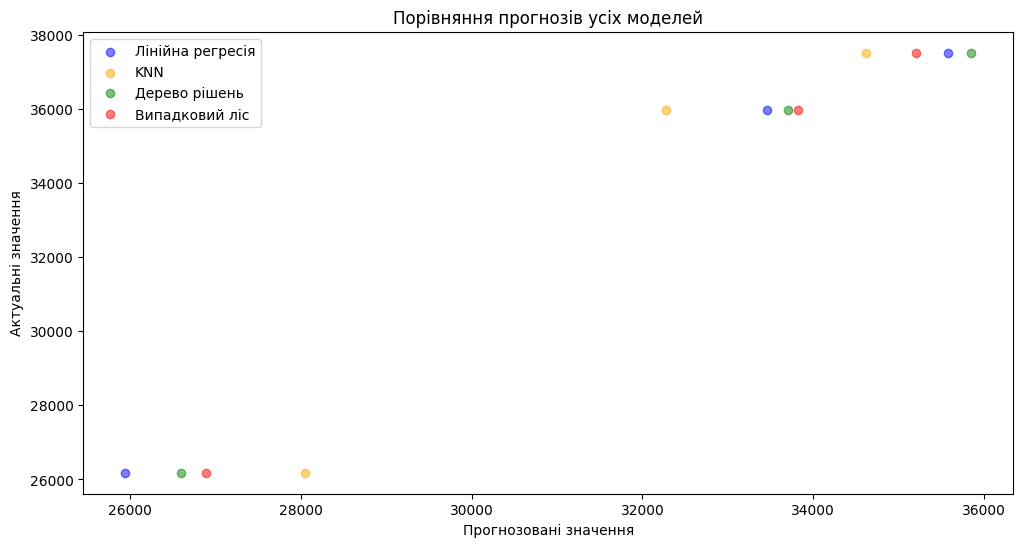

In [145]:
# Візуалізація результатів
plt.figure(figsize=(12, 6))
plt.scatter(predictions, y_test, label='Лінійна регресія', color='blue', alpha=0.5)
plt.scatter(knn_predictions, y_test, label='KNN', color='orange', alpha=0.5)
plt.scatter(tree_predictions, y_test, label='Дерево рішень', color='green', alpha=0.5)
plt.scatter(rf_predictions, y_test, label='Випадковий ліс', color='red', alpha=0.5)
plt.xlabel('Прогнозовані значення')
plt.ylabel('Актуальні значення')
plt.title('Порівняння прогнозів усіх моделей')
plt.legend()
plt.show()

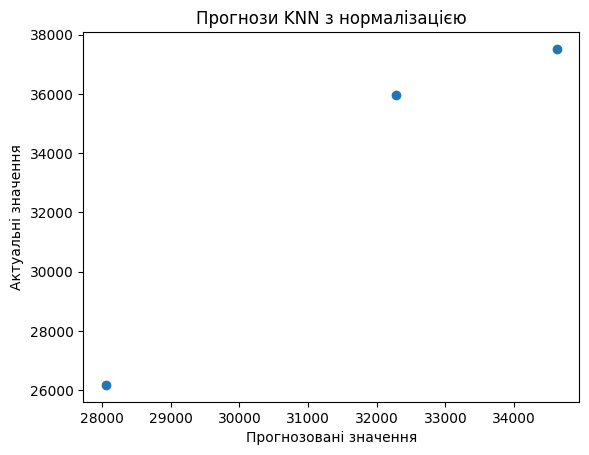

In [146]:
# Пайплайн для моделі KNN
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsRegressor())
])
pred = pipe.fit(X_train, y_train).predict(X_test)
plt.scatter(pred, y_test)
plt.xlabel('Прогнозовані значення')
plt.ylabel('Актуальні значення')
plt.title('Прогнози KNN з нормалізацією')
plt.show()

In [147]:
# Грид-серч для оптимізації параметрів
mod_grid = GridSearchCV(estimator=pipe,
                        param_grid={'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7]},
                        cv=3)
mod_grid.fit(X_train, y_train)
print(pd.DataFrame(mod_grid.cv_results_))


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002245      0.000339         0.001002        0.000002   
1       0.001873      0.000668         0.001610        0.000864   
2       0.002011      0.000011         0.003402        0.001703   
3       0.001695      0.000490         0.003654        0.000388   
4       0.001724      0.000511         0.003718        0.000070   
5       0.002050      0.000033         0.003254        0.000193   
6       0.001706      0.000499         0.003875        0.000294   

   param_model__n_neighbors                     params  split0_test_score  \
0                         1  {'model__n_neighbors': 1}           0.912529   
1                         2  {'model__n_neighbors': 2}           0.977592   
2                         3  {'model__n_neighbors': 3}           0.834099   
3                         4  {'model__n_neighbors': 4}           0.672958   
4                         5  {'model__n_neighbors': 5}           0.448056   
5

In [148]:
# Найкращі параметри
print(f"Найкращі параметри KNN: {mod_grid.best_params_}")


Найкращі параметри KNN: {'model__n_neighbors': 3}


In [149]:
# Оцінка моделей
# Функція для обчислення MSE
def calculate_mse(true_values, predictions):
    return np.mean((true_values - predictions) ** 2)

# Обчислюємо MSE для кожної моделі
mse_linear = calculate_mse(y_test, predictions)
mse_knn = calculate_mse(y_test, knn_predictions)
mse_tree = calculate_mse(y_test, tree_predictions)
mse_rf = calculate_mse(y_test, rf_predictions)

print(f"Середня квадратична похибка (Лінійна регресія): {mse_linear:.2f}")
print(f"Середня квадратична похибка (KNN): {mse_knn:.2f}")
print(f"Середня квадратична похибка (Дерево рішень): {mse_tree:.2f}")
print(f"Середня квадратична похибка (Випадковий ліс): {mse_rf:.2f}")


Середня квадратична похибка (Лінійна регресія): 3393159.56
Середня квадратична похибка (KNN): 8544666.67
Середня квадратична похибка (Дерево рішень): 2703300.00
Середня квадратична похибка (Випадковий ліс): 3501579.10
